SOLO AÑADIR COSAS DEBAJO DEL CHUNK DE CADA NOMBRE

ESTA PARTE ES PARA JAVIER

# ESTA PARTE ES PARA ALMODOVAR

We are first going to updload all the data avaliable and try to understand it

In [100]:
import pandas as pd
import matplotlib as plt
import time
start_serial=time.time()
data1=pd.read_csv("DATA/tripdata_2017-01.csv",header=0)
data2=pd.read_csv("DATA/tripdata_2017-02.csv",header=0)

serial_dataset=pd.concat([data1,data2])

serial_dataset.columns.values
serial_dataset.shape

(1942420, 17)

# 3 - Type of payment in terms of different pick up zones

We are going to try first to do an analysisis that uses serial computation and basic libraries from python to analyse the mean price of travels for the different pick-up zones and payment methods.

We see that we have four levels for the payment method:

 - Credit Card "1"
 - Cash "2"
 - No charge "3"
 - Dispute "4"

<AxesSubplot:xlabel='DOLocationID'>

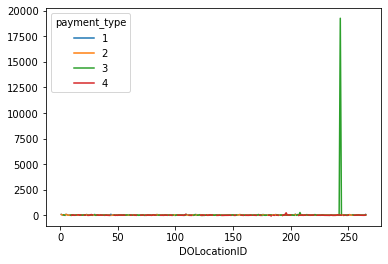

In [101]:
fourth_analysis=serial_dataset.loc[:,['DOLocationID','payment_type','total_amount']]
fourth_analysis.groupby(['DOLocationID','payment_type'])['total_amount'].mean().unstack().plot()

We can see that there must be an error on on or few observations as the mean price for one of the zones goes up to almost 20000 dollars, therefore we are now going to remove it visualice a more reasonable plot.

<AxesSubplot:xlabel='DOLocationID'>

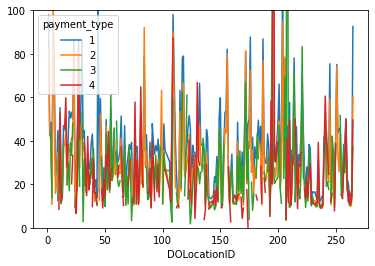

In [102]:
a=fourth_analysis.index[(fourth_analysis['total_amount']>1000) | (fourth_analysis['total_amount']<0)]
fourth_analysis=fourth_analysis.drop(a,axis=0)
fourth_analysis.groupby(['DOLocationID','payment_type'])['total_amount'].mean().unstack().plot(ylim=[0,100],)

As we can see, in general, the payment method most used for the most expensive trips is isually by credit card. However there is also a lot of trips that are out of charge and that those trips with disputes to pay are for low amounts.

Now let's check how is the mean price distributed for each payment method.

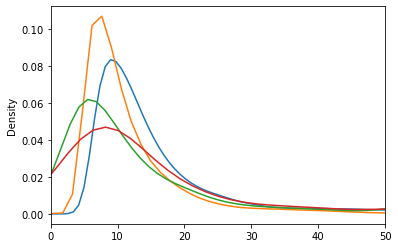

In [103]:
fourth_analysis.groupby(["payment_type"])["total_amount"].plot(kind='density',xlim=[0,50],xlabel="Price")
end_serial=time.time()

We can see that morarles the main payment price is concentrated over the same quantity, between 5 and 10 dollars. Nevertheless we can see that in general most payment method used is the cash and the mean value of trips is a little bit lower than the credit ones. 

Now that we have completed our analysis using a serial version of our problem we can check the system time requiered for it.

In [104]:
print(end_serial-start_serial)

21.88146185874939


## Analysis using SPARK

First of all we have to get the data. In contrast with what we did on the serial version, now we use a moethod from spark to get both datasets directly into 1 object. Using spark we are direcly creating an RDD object.

In [105]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession.builder.appName("prueba").master("local[*]").getOrCreate()
start2=time.time()
spark_dataset = spark.read.option("header","true").option("inferSchema","true").csv("DATA/*.csv")

In [106]:
spark_dataset=spark_dataset.select(['DOLocationID','total_amount','payment_type'])
spark_dataset_groupped=spark_dataset.groupBy('DOLocationID','payment_type').avg('total_amount')

We now want to plot the data. As pyspark does not have any method to directly plot the data, we will use a function from matplotlib.pyplot that allows to plot data withoud having to convert it back to pandas and plot it. 

No handles with labels found to put in legend.


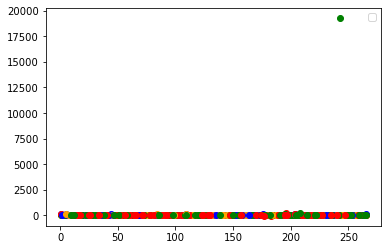

In [107]:
to_plot=spark_dataset_groupped.collect()
for i in range(len(to_plot)):
    if(to_plot[i][1]==1):
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="blue")
    elif(to_plot[i][1]==2):
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="orange")
    elif(to_plot[i][1]==3):
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="green")
    else:
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="red")
plt.legend()
plt.show()


Again, as we can see there is at least one observation that we do not want to consider so we will delete it for this analysis.

In [108]:
spark_cleaned=spark_dataset.where(spark_dataset.total_amount<=1000)
spark_cleaned=spark_cleaned.where(spark_cleaned.total_amount>0)
spark_dataset_cleaned_groupped=spark_cleaned.groupBy('DOLocationID','payment_type').avg('total_amount')
to_plot_cleaned=spark_dataset_cleaned_groupped.collect()

No handles with labels found to put in legend.


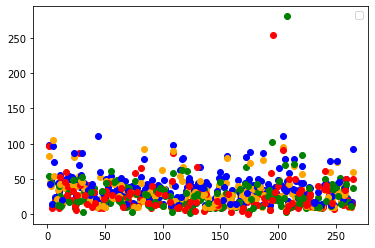

In [109]:

for i in range(len(to_plot_cleaned)):
    if(to_plot_cleaned[i][1]==1):
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="blue")
    elif(to_plot_cleaned[i][1]==2):
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="orange")
    elif(to_plot_cleaned[i][1]==3):
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="green")
    else:
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="red")
plt.legend()
plt.show()


In [110]:
density_plot=spark_cleaned.select(['payment_type','total_amount'])
density_groupped=density_plot.rdd
density_spark=density_groupped.groupByKey().collect()

Again, as we do not have any options to do plots inside spark we have to use other methods to do so. For this case we have decided to use a function provided by seaborn to do density plots.

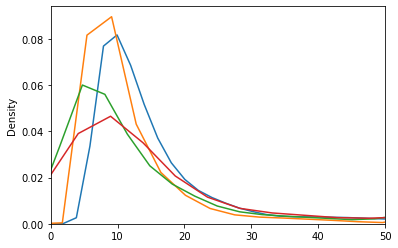

In [111]:
for key, value in density_spark:
    if(key==1):
        x_1=list(value)
    elif(key==2):
        x_2=list(value)
    elif(key==3):
        x_3=list(value)
    else:
        x_4=list(value)

sns.kdeplot(x_1)
sns.kdeplot(x_2)
sns.kdeplot(x_3)
sns.kdeplot(x_4)
plt.xlim(0,50)
stop2=time.time()


Even though the plot given now is not as smoth as the density given for the serial version, the analysis is the same. This is just due to the fact that this kde function calculates a different bandwith.

In [112]:
print(stop2-start2)
spark.stop()

16.772948026657104


ESTA PARTE ES PARA ALBERTO